In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [6]:
#We read the RV datafile of HD81040.
df_raw = pd.read_csv('../../data/astrvdata/hd81040.txt')

#We only take "bjd", "rv" and "e_rv" columns from the df_raw as follows. (We basically remove other columns)
df = df_raw[['bjd','rv','e_rv']]

#Then we define the columns as "time", "mnvel" and "errvel" as follows.
df.columns = ['time','mnvel','errvel']

df

,time,mnvel,errvel
0,2.451291e+06,49.319,0.012
1,2.451293e+06,49.312,0.014
2,2.451546e+06,49.088,0.009
3,2.452309e+06,49.399,0.012
4,2.452356e+06,49.412,0.021
5,2.452359e+06,49.363,0.012
6,2.452360e+06,49.391,0.011
7,2.452616e+06,49.119,0.011
8,2.452650e+06,49.126,0.011
9,2.452650e+06,49.129,0.013


In [7]:
#We take the Times, RV and RV Errors from the dataframe.
#Note that we are converting from km/s to m/s, hence the multiplication by 1000.
times = df.time.values
rv = (df.mnvel.values - np.median(df.mnvel.values)) * 1000
e_rv = df.errvel.values * 1000

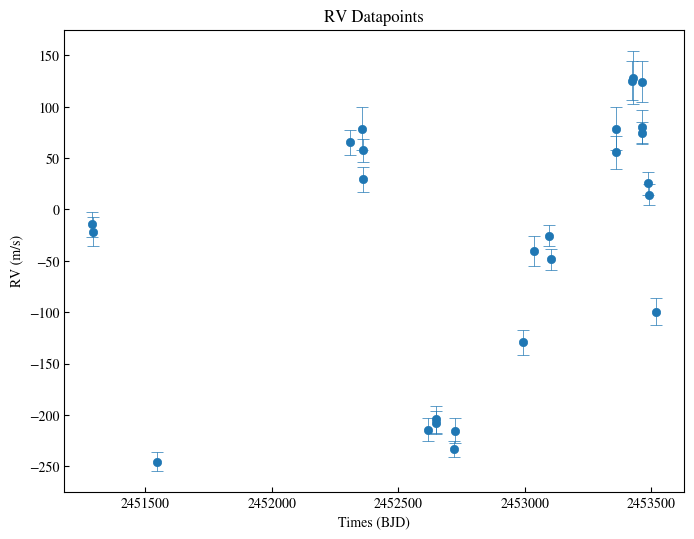

In [8]:
#We plot our RV data as follows.
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(times, rv, e_rv, marker = "o", lw = 0, mew = 0.5, capsize = 4, elinewidth = 0.5)

ax.set_title("RV Datapoints")
ax.set_xlabel("Times (BJD)")
ax.set_ylabel("RV (m/s)")

plt.show()

In [9]:
#Now we import the source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafit
import gaiasource
reload(gaiafit)

gaiafit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafit' from '/home/kayahan/ExoSoft/notebooks/astrometry-rv-tests/../../gaiafit/gaiafit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/astrometry-rv-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/astrometry-rv-tests/../../gaiafit/utils.py'>)

In [10]:
#We then use "GaiaSource" object from "gaiasource.py"
#This object has functions to estimate Semi-Amplitude of RV and the Mass from the Gaia Thiele Innes Coefficients.
#We also input the stellar mass and error, which comes from Winn/Sozzetti 2006.
GS = gaiasource.GaiaSource('../../data/astrvdata/targets_winn.csv', source_index = 1, st_mass = 0.962, st_masserr = 0.001)

#We can then estimate the Mass and Semi-Amplitude as follows.
GS.df_campbell

SOURCE_ID 637329067477530368
Using provided mass
M=7.74-0.86+1.01M_jup
K=176.28-27.39+35.67m/s


,source_id,period,period_error,eccentricity,eccentricity_error,inclination,inclination_error,K,K_error,t_periastron,...,a0_error,nodeangle,nodeangle_error,arg_periastron,arg_periastron_error,parallax,parallax_error,pl_mass,pl_mass_error,st_mass
0,637329067477530368,850.837877,112.527145,0.369314,0.149856,107.780206,5.850928,176.282233,31.529488,145.67734,...,0.03197,12.630506,5.748742,62.788344,14.449634,29.006761,0.025329,7.739262,0.936457,0.962


In [11]:
#Now, we can perform the Gaia-RV Joint Fit.
#For this we need:
    #1-) The prior file for the RV parameters.
    #2-) The RV data (which we have called on the previous cells)
    #3-) Gaia Input Data (in our case "targets_winn.csv")

#We call the prior file.
f = '../../data/astrvpriors/hd81040_priors_RVGaia.txt'

#We then use "LPFunctionGaiaRV" to do the fitting.
#Note that LPFunctionGaiaRV plots the priors.
L = gaiafit.LPFunctionRVGaia(times, rv, e_rv, 
                             filename = '../../data/astrvdata/targets_winn.csv', source_index = 1,
                             file_priors = f)

#We do a Fit for Gaia + RV as follows. (The function needs the Likelihood Function to work)
TF = gaiafit.GaiaFitRVGaia(L)

SOURCE_ID 637329067477530368
Reading in priorfile from ../../data/astrvpriors/hd81040_priors_RVGaia.txt
   prior     arg1      arg2        label  description priortype  fixed
0     NP    0.962     0.040        mstar        mstar     model  False
1     UP    1.000    60.000           mp           mp     model  False
2     UP    0.000     0.900       ecc_p1       ecc_p1     model  False
3     UP    0.000   360.000     omega_p1     omega_p1     model  False
4     UP   -1.000     1.000         cosi         cosi     model  False
5     UP    0.000   360.000        Omega        Omega     model  False
6     UP  500.000  1500.000         P_p1         P_p1     model  False
7     UP -500.000   500.000        tp_p1        tp_p1     model  False
8     NP   29.010     0.024          plx          plx     model  False
9     FP    0.000     0.000          eps          eps     model   True
10    UP -400.000   400.000        gamma        gamma     model  False
11    FP    0.000     0.000     sigma_rv    

In [12]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=20000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels   centers    lower     upper           pv  center_dist
0     mstar     0.962    0.762     1.162     0.764094     0.197906
1        mp    30.500    1.000    60.000    59.932698   -29.432698
2    ecc_p1     0.450    0.000     0.900     0.001301     0.448699
3  omega_p1   180.000    0.000   360.000   206.912528   -26.912528
4      cosi     0.000   -1.000     1.000     0.996374    -0.996374
5     Omega   180.000    0.000   360.000   197.275941   -17.275941
6      P_p1  1000.000  500.000  1500.000  1499.643584  -499.643584
7     tp_p1     0.000 -500.000   500.000   483.351898  -483.351898
8       plx    29.010   28.890    29.130    29.039103    -0.029103
9     gamma     0.000 -400.000   400.000   -82.210384    82.210384
LogPost value: 569121.8684362663
LnL value: 569166.6701855157
Log priors -44.801749249339785
Running MCMC
MCMC iterations= 20000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 2

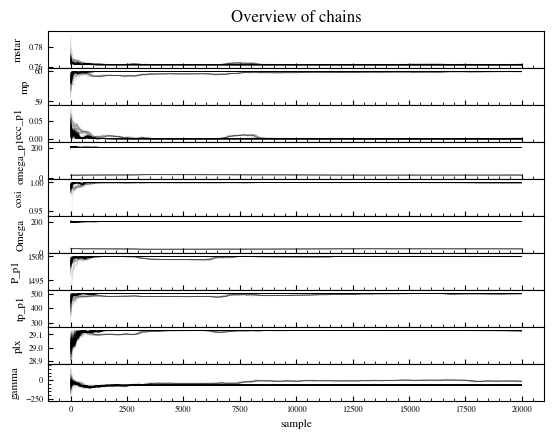

In [13]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [14]:
#We now aim to make the Flatchain and Posteriors.
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase. (?)
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

,mstar,mp,ecc_p1,omega_p1,cosi,Omega,P_p1,tp_p1,plx,gamma
0,0.762210,59.992562,0.000487,202.414012,0.999853,200.594669,1499.975095,495.636238,29.124509,-88.998861
1,0.762210,59.992562,0.000487,202.414012,0.999853,200.594669,1499.975095,495.636238,29.124509,-88.998861
2,0.762189,59.993903,0.000472,202.406116,0.999816,200.578802,1499.985191,495.811732,29.124361,-86.484149
3,0.762189,59.993903,0.000472,202.406116,0.999816,200.578802,1499.985191,495.811732,29.124361,-86.484149
4,0.762189,59.993903,0.000472,202.406116,0.999816,200.578802,1499.985191,495.811732,29.124361,-86.484149
...,...,...,...,...,...,...,...,...,...,...
1899995,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949
1899996,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949
1899997,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949
1899998,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949


In [15]:
#A method for checking if the chains have converged is: Checking the GR statistic.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR STATISTICS")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
mcmc_help.plot_chains(chains_after_burnin,labels=TF.lpf.ps_vary.labels)
print(50 * "-")

GR STATISTICS
--------------------------------------------------
[  1.309373     1.4891805    1.13180432 141.13852636   2.29973423
 132.19479055   1.14624193   1.55425182   1.09799611   1.78889953]
--------------------------------------------------


In [16]:
#We check the known Thiele Innes Coefficient values from Gaia.
TF.lpf.df_known

,label,median,error
0,A,0.195897,0.079865
1,B,-0.063934,0.040788
2,F,-0.324407,0.056696
3,G,-0.128140,0.042197
4,e,0.369314,0.149856
5,P,850.837877,112.527145
6,t_peri,145.677340,68.638020


In [17]:
#We also check the Covariance Matrix, "C Matrix".
TF.lpf.C

,a_thiele_innes,b_thiele_innes,f_thiele_innes,g_thiele_innes,eccentricity,period,t_periastron
a_thiele_innes,0.006378,0.001839,0.003520,-0.000948,0.001939,1.638565,-4.714584
b_thiele_innes,0.001839,0.001664,0.001301,0.000159,-0.000313,-0.168007,-1.515231
f_thiele_innes,0.003520,0.001301,0.003214,-0.000366,-0.002545,-1.950001,-1.862900
g_thiele_innes,-0.000948,0.000159,-0.000366,0.001781,-0.002993,-2.541454,1.257802
period,1.638565,-0.168007,-1.950001,-2.541454,14.179651,12662.358362,-4704.520361
eccentricity,0.001939,-0.000313,-0.002545,-0.002993,0.022457,14.179651,-5.081229
t_periastron,-4.714584,-1.515231,-1.862900,1.257802,-5.081229,-4704.520361,4711.177790


In [18]:
#We can also check the posteriors as follows.
df_post, df_mean = TF.calculate_derived_params(df_post)
df_post

,mstar,mp,ecc_p1,omega_p1,cosi,Omega,P_p1,tp_p1,plx,gamma,i,a0,K_p1,A,B,F,G
0,0.762210,59.992562,0.000487,202.414012,0.999853,200.594669,1499.975095,495.636238,29.124509,-88.998861,0.982142,4.884350,20.849033,3.571779,3.331404,-3.331426,-4.881267
1,0.762210,59.992562,0.000487,202.414012,0.999853,200.594669,1499.975095,495.636238,29.124509,-88.998861,0.982142,4.884350,20.849033,3.571779,3.331404,-3.331426,-4.881267
2,0.762189,59.993903,0.000472,202.406116,0.999816,200.578802,1499.985191,495.811732,29.124361,-86.484149,1.098143,4.884536,23.312085,3.573320,3.329985,-3.330014,-4.881276
3,0.762189,59.993903,0.000472,202.406116,0.999816,200.578802,1499.985191,495.811732,29.124361,-86.484149,1.098143,4.884536,23.312085,3.573320,3.329985,-3.330014,-4.881276
4,0.762189,59.993903,0.000472,202.406116,0.999816,200.578802,1499.985191,495.811732,29.124361,-86.484149,1.098143,4.884536,23.312085,3.573320,3.329985,-3.330014,-4.881276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899995,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949,0.007267,4.886732,0.154306,3.553465,3.354553,-3.354553,-4.886659
1899996,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949,0.007267,4.886732,0.154306,3.553465,3.354553,-3.354553,-4.886659
1899997,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949,0.007267,4.886732,0.154306,3.553465,3.354553,-3.354553,-4.886659
1899998,0.762000,59.999957,0.000026,201.519235,1.000000,201.831427,1499.999608,499.998024,29.129998,-68.017949,0.007267,4.886732,0.154306,3.553465,3.354553,-3.354553,-4.886659


In [19]:
#We can check the parameter posteriors from the fit results as follows.
df_mean[['Labels','values']]

,Labels,values
0,mstar,$0.7620032_{-0.000003}^{+0.00004}$
0,mp,$59.99982_{-0.0056}^{+0.00014}$
0,ecc_p1,$2e-05_{-0.00002}^{+0.00011}$
0,omega_p1,$201.65_{-29.0}^{+0.15}$
0,cosi,$0.999999967_{-0.00016}^{+0.00000003}$
0,Omega,$201.64_{-30.0}^{+0.14}$
0,P_p1,$1499.99919_{-0.0049}^{+0.00063}$
0,tp_p1,$499.979_{-0.63}^{+0.016}$
0,plx,$29.129924_{-0.00032}^{+0.00006}$
0,gamma,$-66.5_{-3.0}^{+4.7}$


In [20]:
# #We can also check the Z-score panel with the following.
# #Note that Z-Score panel shows the standard deviations of the parameters from the respective parameters mean.
# TF.plot_zscore_panel();

In [21]:
#We then plot the Corner plot.
# import corner
# corner.corner(df_post.values,
#        show_titles=True,labels=list(df_post.columns),title_fmt='.1f',xlabcord=(0.5, -0.2));

In [22]:
# # Plot corner plot
# fig = mcmc_help.plot_corner(chains_after_burnin,
#        show_titles=True,labels=np.array(TF.lpf.ps_vary.descriptions),title_fmt='.1f',xlabcord=(0.5, -0.2),
#        truths=[0.741,5.16*316.82,0.5439,113.846,0.149,126.0507,655.57,-138.5,28.99,0])

In [23]:
# Print median values
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals

,medvals,minus,plus,values,Labels,Description
0,0.762003,0.000003,3.586902e-05,$0.7620032_{-0.000003}^{+0.00004}$,mstar,mstar
0,59.999824,0.005639,1.365864e-04,$59.99982_{-0.0056}^{+0.00014}$,mp,mp
0,0.000020,0.000015,1.128238e-04,$2e-05_{-0.00002}^{+0.00011}$,ecc_p1,ecc_p1
0,201.650453,29.433546,1.507906e-01,$201.65_{-29.0}^{+0.15}$,omega_p1,omega_p1
0,1.000000,0.000164,2.819130e-08,$0.999999967_{-0.00016}^{+0.00000003}$,cosi,cosi
0,201.635667,29.909923,1.413344e-01,$201.64_{-30.0}^{+0.14}$,Omega,Omega
0,1499.999191,0.004929,6.304591e-04,$1499.99919_{-0.0049}^{+0.00063}$,P_p1,P_p1
0,499.979149,0.633354,1.618148e-02,$499.979_{-0.63}^{+0.016}$,tp_p1,tp_p1
0,29.129924,0.000317,5.817851e-05,$29.129924_{-0.00032}^{+0.00006}$,plx,plx
0,-66.472264,3.011547,4.653917e+00,$-66.5_{-3.0}^{+4.7}$,gamma,gamma


Sampling, i= 0
Sampling, i= 100
Sampling, i= 200
Sampling, i= 300


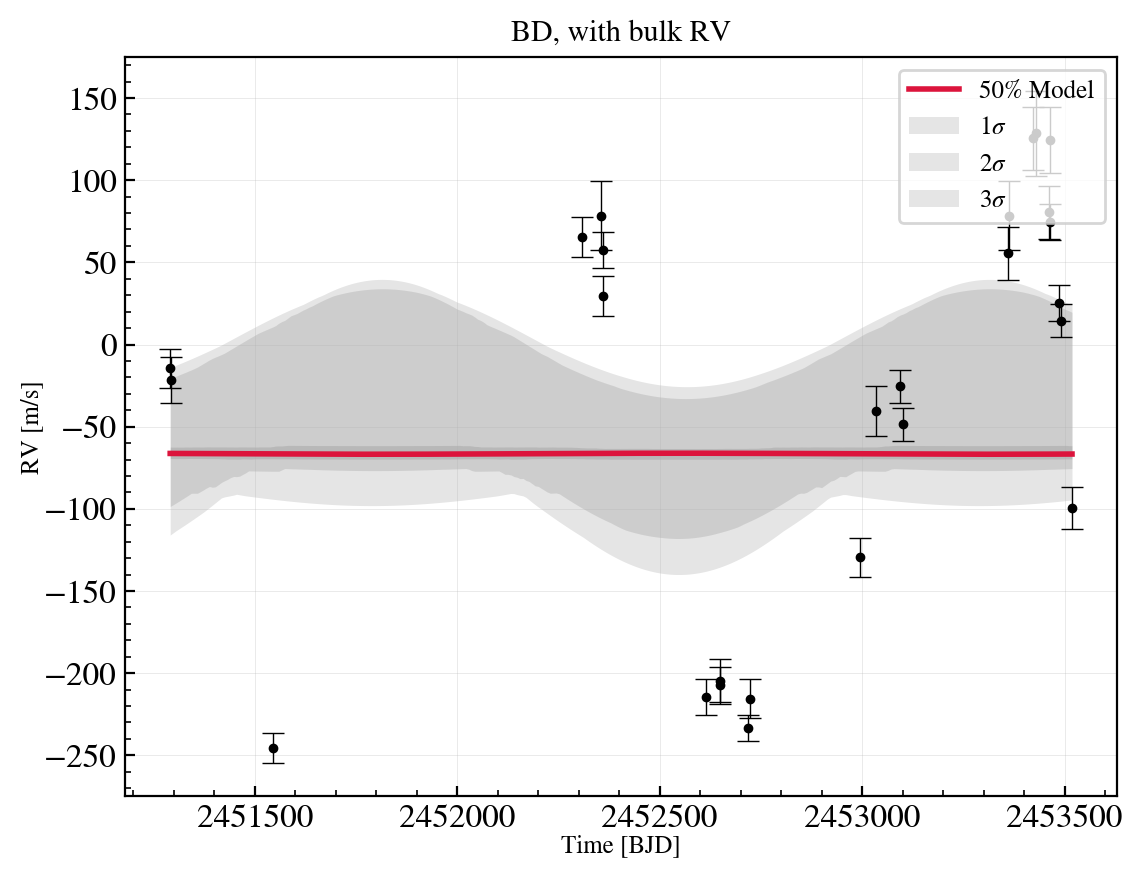

In [25]:
import utils
TITLE = 'BD, with bulk RV'
NUMMODELS = 400
shadecolor="black"

###################
times1 = np.linspace(TF.lpf.data['x'][0]-0.02,TF.lpf.data['x'][-1]+0.02,500)
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
t1_mod = np.linspace(times1.min()-0.02,times1.max()+0.02,300)
rv_50 = TF.lpf.compute_total_model(pv_50,t1_mod)

# Plot random samples
fig, ax = plt.subplots(dpi=200)

#################
# Plot data
#################
markercolor="black"
ax.errorbar(TF.lpf.data['x'],TF.lpf.data['y'],TF.lpf.data['error'],
            marker='o',elinewidth=0.5,capsize=4,lw=0,mew=0.5,color=markercolor,markersize=3)
ax.plot(t1_mod,rv_50,color="crimson",
        label=r'50% Model',lw=2.,zorder=10)

#################
# Sample models
#################
mmodel1 = []
for i in range(NUMMODELS):
    if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)
#################

ax.fill_between(t1_mod,np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='1$\sigma$',zorder=-1)
ax.fill_between(t1_mod,np.quantile(mmodel1,0.02,axis=0),np.quantile(mmodel1,0.98,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
ax.fill_between(t1_mod,np.quantile(mmodel1,0.0015,axis=0),np.quantile(mmodel1,0.9985,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)
ax.legend(loc='upper right')
ax.set_xlabel('Time [BJD]',labelpad=0)
ax.set_ylabel('RV [m/s]',labelpad=0)
ax.set_title(TITLE)
utils.ax_apply_settings(ax)

plt.show();